Desafio redes neurais convolucionais, Gustavo Alves

Dados: classificando nuvens usando cnn(link: https://www.kaggle.com/competitions/classificandos-nuvens-usando-cnn)

Parte 1: Criação de uma CNN

Importação das bibliotecas utilizadas na implementação na rede convolucional multiclasse:

In [85]:
import pandas as pd                                     # criação de datasets
import torch                                            # módulo principal torch
import torch.nn as nn                                   # camadas de redes neurais      
from torchvision import datasets, transforms            # carregar datasets e aplicar transformações nas imagens
from torch.utils.data import DataLoader                 # criar batches , embaralhar dados e otimizar carregamento
import torch.nn.functional as F                         # define as funções de nn.functional como F
from PIL import Image                                   # abrir e manipular imagens
import matplotlib.pyplot as plt                         # visualização das imagens
from sklearn.metrics import classification_report       # usado na avaliação do modelo

Como primeiro passo da nossa resolução, precisamos carregar nossas imagens e transformá-las em tensores para que nossa rede neural possa utilizar essas imagens. Além disso, vamos aplicar métodos de transformação(Data Augmentation) a fim de evitar o overfitting de dados.

In [86]:
# transaforma em um tensor [3, 224, 224]

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # Inverte horizontalmente a imagem com uma probabilidade de 0.5
    transforms.RandomRotation(45),     # Rotaciona a imagem aleatoriamente em até 45 graus
    transforms.RandomAutocontrast(),   # Ajusta o contraste da imagem aleatoriamente
    transforms.Resize((224, 224)),     # Dimensão 224 x 224(Tamanho padrão de redes famosas)
    transforms.ToTensor(),             # Converte para Tensor
    
])

# carrega as imagens de treino e de teste

train_dataset = datasets.ImageFolder(root="Trainee-CIS/clouds/clouds_train", transform=transform)
test_dataset = datasets.ImageFolder(root="Trainee-CIS/clouds/clouds_test", transform=transform)

# DataLoaders para carregar batches(32)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# verifica se separamos corretamente

image, label = next(iter(train_dataset))
print(f"Formato dos dados de treino: {image.shape}") # tensor [3, 224, 224]
print("Classes: ", train_dataset.classes)


Formato dos dados de treino: torch.Size([3, 224, 224])
Classes:  ['cirriform clouds', 'clear sky', 'cumulonimbus clouds', 'cumulus clouds', 'high cumuliform clouds', 'stratiform clouds', 'stratocumulus clouds']


Ótimo! Vamos ver como algumas das imagens do nosso dataset se parecem:

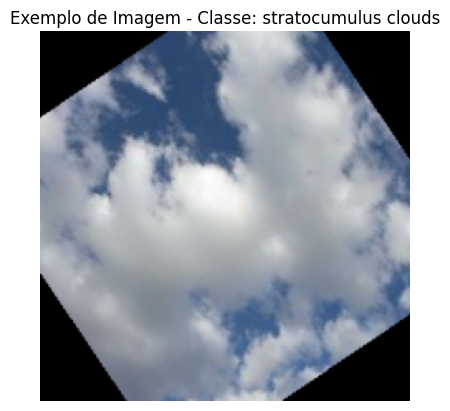

In [87]:

# seleciona a primeira imagem e rótulo do batch
image, label = next(iter(train_loader))
primeira_imagem = image[0]
primeiro_label = label[0]

# Prepara para plotagem (permute de [C, H, W] para [H, W, C])

primeira_imagem = primeira_imagem.permute(1, 2, 0)

# mostra a imagem

plt.imshow(primeira_imagem)
plt.title(f"Exemplo de Imagem - Classe: {train_dataset.classes[primeiro_label]}")
plt.axis("off")
plt.show()


Agora, precisamos construir o nosso modelo CNN!

Para isso, criamos a classe CNN que define uma arquitetura de rede neural convolucional para tarefas de classificação de imagens. Essa rede é composta por:

1) 3 camadas convolucionais com normalização por lote (batch normalization)

2) Funções de ativação ReLU

3) Camadas de pooling para redução de dimensionalidade

4) Camadas totalmente conectadas (fully connected) para classificação final

In [88]:

class CNN(nn.Module):

    # inicia a CNN a partir do número de classes que queremos classificar
    def __init__(self, num_classes):

        super(CNN, self).__init__()
        
        # 1ª camada conv: RGB(3 canais) para 16 canais, kernel 3x3
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)   # normaliza os 16 canais
        self.pool = nn.MaxPool2d(2, 2)  # pooling para reduzir dimensão pela metade

        # 2ª camada conv: 16 para 32 canais
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)   # normaliza os 32 canais

        # 3ª camada conv: 32 para 64 canais
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)   # normaliza os 64 canais

        # depois de 3 camadas conv com pooling, a dimensão cai para 28x28
        self.fc1 = nn.Linear(64 * 28 * 28, 512) #
        self.fc2 = nn.Linear(512, num_classes)  # 512 -> número de classes
        self.dropout = nn.Dropout(0.5)          # dropout para evitar overfitting

    # definição da função forward para o pytorch operar
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # conv1 + batchnorm + ReLU + pooling
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # conv2 + batchnorm + ReLU + pooling
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # conv3 + batchnorm + ReLU + pooling
        x = x.view(-1, 64 * 28 * 28)                    # achatamento para camada fully connected
        x = self.dropout(F.relu(self.fc1(x)))           # ReLU + dropout
        x = self.fc2(x)                                 # camada final
        return x


Agora, vamos definir o nome do nosso modelo, nossa função de perda e nosso otimizador:

In [89]:
model = CNN(num_classes=len(train_dataset.classes))             # modelo com 7 classes
criterion = nn.CrossEntropyLoss()                               # função de perda(softmax)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)      # otimizador(Adam)

print("Modelo criado:")
print(model)

Modelo criado:
CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=7, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


Perfeito. Agora, vamos definir como vai ser nosso treino:

In [90]:

for epoch in range(20):                     # 20 epochs

    model.train()                           # coloca o modelo em modo de treino
    running_loss = 0.0                      # acumula perda do modelo
    correct = 0                             # contador de acertos
    total = 0                               # total de amostras

    for inputs, labels in train_loader:

        optimizer.zero_grad()               # zera os gradientes acumulados da iteração anterior
        outputs = model(inputs)             # forward pass
        loss = criterion(outputs, labels)   # calcula a perda entre a saída e rótulos
        loss.backward()                     # backpropagation
        optimizer.step()                    # atualiza os pesos

        running_loss += loss.item() * 32                # acumula loss ponderado pelo tamanho do batch(32)
        _, predicted = outputs.max(1)                   # pega as classes com maior probabilidade
        total += 32                                     # atualiza total de amostras
        correct += predicted.eq(labels).sum().item()    # atualiza número de acertos

    epoch_loss = running_loss / total       # calcula perda média
    epoch_acc = correct / total             # calcula acurácia da época

    print(f"Época {epoch+1}/10 - Perda: {epoch_loss:.2f} - Acurácia: {epoch_acc:.4f}")

    # Avaliação no conjunto de validação
    model.eval()                            # modo avaliação 
    val_loss = 0.0                          # acumula perda 
    val_correct = 0                         # contador de acertos
    val_total = 0                           # total de amostras

    with torch.no_grad():
        for inputs, labels in test_loader:

            outputs = model(inputs)                                     # forward pass
            loss = criterion(outputs, labels)                           # calcula a perda entre a saída e rótulos
            val_loss += loss.item() * 32                                # acumula loss ponderado pelo tamanho do batch(32)
            _, predicted = outputs.max(1)                               # pega as classes com maior probabilidade
            val_total += 32                                             # atualiza total de amostras
            val_correct += predicted.eq(labels).sum().item()            # atualiza número de acertos

    val_loss = val_loss / val_total         # calcula perda média
    val_acc = val_correct / val_total       # calcula acurácia do teste
    print(f"Validação  - Perda: {val_loss:.2f} - Acurácia: {val_acc:.2f}")



Época 1/10 - Perda: 18.50 - Acurácia: 0.2333
Validação   - Perda: 6.14 - Acurácia: 0.15
Época 2/10 - Perda: 4.93 - Acurácia: 0.2917
Validação   - Perda: 2.43 - Acurácia: 0.15
Época 3/10 - Perda: 1.77 - Acurácia: 0.3563
Validação   - Perda: 1.56 - Acurácia: 0.40
Época 4/10 - Perda: 1.50 - Acurácia: 0.4208
Validação   - Perda: 1.57 - Acurácia: 0.38
Época 5/10 - Perda: 1.30 - Acurácia: 0.4833
Validação   - Perda: 1.22 - Acurácia: 0.47
Época 6/10 - Perda: 1.28 - Acurácia: 0.5042
Validação   - Perda: 1.17 - Acurácia: 0.47
Época 7/10 - Perda: 1.08 - Acurácia: 0.5833
Validação   - Perda: 5.63 - Acurácia: 0.23
Época 8/10 - Perda: 1.09 - Acurácia: 0.5708
Validação   - Perda: 1.38 - Acurácia: 0.47
Época 9/10 - Perda: 1.10 - Acurácia: 0.5542
Validação   - Perda: 1.01 - Acurácia: 0.60
Época 10/10 - Perda: 1.08 - Acurácia: 0.5979
Validação   - Perda: 1.27 - Acurácia: 0.51
Época 11/10 - Perda: 1.07 - Acurácia: 0.5771
Validação   - Perda: 0.94 - Acurácia: 0.60
Época 12/10 - Perda: 0.94 - Acurácia: 0.

O modelo apresentou uma melhora consistente na acurácia de treino, subindo de 23% na época 1 para quase 66% na época 20, o que indica que ele foi capaz de aprender padrões dos dados ao longo do tempo.

A perda de treinamento também reduziu consideravelmente, indo de 18.50 para 0.89, reforçando que o modelo está ajustando bem seus pesos durante o aprendizado.

A acurácia de validação oscilou bastante, começando em 15%, atingindo 60% nas épocas 9, 11 e 20, com algumas quedas significativas (ex: 23% na época 7), o que pode indicar algum nível de instabilidade ou sensibilidade à variação dos dados.

Apesar disso, a tendência geral foi de melhora, e o modelo conseguiu se aproximar de sua melhor performance ao final das 20 épocas, com 0.94 de perda e 60% de acurácia no conjunto de validação.

Por fim, vamos gerar um relatório de classificação por classe:

In [ ]:
# Coleta de previsões e rótulos verdadeiros
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# lista com nomes das classes 
class_names = train_dataset.classes  

# relatório de classificação
print("\nRelatório por Classe:")
print(classification_report(all_labels, all_preds, target_names=class_names))


Relatório por Classe:
                        precision    recall  f1-score   support

      cirriform clouds       0.47      0.83      0.60        77
             clear sky       0.87      0.75      0.81        64
   cumulonimbus clouds       1.00      0.55      0.71        11
        cumulus clouds       0.83      0.52      0.64       120
high cumuliform clouds       0.55      0.83      0.66       103
     stratiform clouds       0.94      0.72      0.82        40
  stratocumulus clouds       0.77      0.32      0.46        71

              accuracy                           0.65       486
             macro avg       0.78      0.65      0.67       486
          weighted avg       0.72      0.65      0.65       486



Conclusão final:

O modelo evoluiu bem ao longo do treinamento, alcançando um desempenho razoável na tarefa de classificação de nuvens. Com uma acurácia final de 65% na validação e um f1-score médio de 0.65, ele mostra ser capaz de generalizar para o conjunto de teste, embora com variabilidade no desempenho entre classes. Tivemos destaque positivo para algumas delas, como "clear sky" e "stratiform clouds" com um alto score F1, porém algumas classes como "stratocumulus clouds" tiveram score F1 abaixo.


Próximos passos para melhorar nossa CNN:

1) Balanceamento do dataset;

2) Testar mais técnicas de data augmentation;

3) Explorar regularização ou fine-tuning de hiperparâmetros.


Parte 2: Transfer Learning

Importação do modelo:

In [92]:
import torchvision.models as models

# modelo pré-treinado : resnet18
model = models.resnet18(pretrained=True)

/home/new-fring/Documentos/analise_dados/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/new-fring/Documentos/analise_dados/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/new-fring/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100.0%


Adicionando parâmetros do modelo:

In [93]:
# congela as camadas convolucionais
for param in model.parameters():
    param.requires_grad = False

# substitui a camada final 
num_classes = len(train_dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)

#  otimizador e perda
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

Aqui podemos repetir o código anterior do nosso treino, a única diferença será o modelo que estaremos utilizando.

In [95]:

for epoch in range(10):                     # 10 epochs

    model.train()                           # coloca o modelo em modo de treino
    running_loss = 0.0                      # acumula perda do modelo
    correct = 0                             # contador de acertos
    total = 0                               # total de amostras

    for inputs, labels in train_loader:

        optimizer.zero_grad()               # zera os gradientes acumulados da iteração anterior
        outputs = model(inputs)             # forward pass
        loss = criterion(outputs, labels)   # calcula a perda entre a saída e rótulos
        loss.backward()                     # backpropagation
        optimizer.step()                    # atualiza os pesos

        running_loss += loss.item() * 32                # acumula loss ponderado pelo tamanho do batch(32)
        _, predicted = outputs.max(1)                   # pega as classes com maior probabilidade
        total += 32                                     # atualiza total de amostras
        correct += predicted.eq(labels).sum().item()    # atualiza número de acertos

    epoch_loss = running_loss / total       # calcula perda média
    epoch_acc = correct / total             # calcula acurácia da época

    print(f"Época {epoch+1}/10 - Perda: {epoch_loss:.2f} - Acurácia: {epoch_acc:.4f}")

    # Avaliação no conjunto de validação
    model.eval()                            # modo avaliação 
    val_loss = 0.0                          # acumula perda 
    val_correct = 0                         # contador de acertos
    val_total = 0                           # total de amostras

    with torch.no_grad():
        for inputs, labels in test_loader:

            outputs = model(inputs)                                     # forward pass
            loss = criterion(outputs, labels)                           # calcula a perda entre a saída e rótulos
            val_loss += loss.item() * 32                                # acumula loss ponderado pelo tamanho do batch(32)
            _, predicted = outputs.max(1)                               # pega as classes com maior probabilidade
            val_total += 32                                             # atualiza total de amostras
            val_correct += predicted.eq(labels).sum().item()            # atualiza número de acertos

    val_loss = val_loss / val_total         # calcula perda média
    val_acc = val_correct / val_total       # calcula acurácia do teste
    print(f"Validação  - Perda: {val_loss:.2f} - Acurácia: {val_acc:.2f}")



Época 1/10 - Perda: 0.47 - Acurácia: 0.8646
Validação  - Perda: 0.49 - Acurácia: 0.80
Época 2/10 - Perda: 0.47 - Acurácia: 0.8500
Validação  - Perda: 0.46 - Acurácia: 0.81
Época 3/10 - Perda: 0.42 - Acurácia: 0.8958
Validação  - Perda: 0.43 - Acurácia: 0.84
Época 4/10 - Perda: 0.40 - Acurácia: 0.8729
Validação  - Perda: 0.42 - Acurácia: 0.82
Época 5/10 - Perda: 0.37 - Acurácia: 0.9062
Validação  - Perda: 0.40 - Acurácia: 0.84
Época 6/10 - Perda: 0.38 - Acurácia: 0.8917
Validação  - Perda: 0.42 - Acurácia: 0.83
Época 7/10 - Perda: 0.39 - Acurácia: 0.8729
Validação  - Perda: 0.41 - Acurácia: 0.84
Época 8/10 - Perda: 0.38 - Acurácia: 0.8708
Validação  - Perda: 0.41 - Acurácia: 0.84
Época 9/10 - Perda: 0.36 - Acurácia: 0.8812
Validação  - Perda: 0.37 - Acurácia: 0.85
Época 10/10 - Perda: 0.32 - Acurácia: 0.9083
Validação  - Perda: 0.40 - Acurácia: 0.83


Relatório de classificação por classe:

In [96]:
# Coleta de previsões e rótulos verdadeiros
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# lista com nomes das classes 
class_names = train_dataset.classes  

# relatório de classificação
print("\nRelatório por Classe:")
print(classification_report(all_labels, all_preds, target_names=class_names))


Relatório por Classe:
                        precision    recall  f1-score   support

      cirriform clouds       0.78      0.96      0.86        77
             clear sky       1.00      0.97      0.98        64
   cumulonimbus clouds       0.67      0.55      0.60        11
        cumulus clouds       0.94      0.85      0.89       120
high cumuliform clouds       0.87      0.86      0.87       103
     stratiform clouds       0.90      0.88      0.89        40
  stratocumulus clouds       0.83      0.82      0.82        71

              accuracy                           0.88       486
             macro avg       0.85      0.84      0.84       486
          weighted avg       0.88      0.88      0.88       486



Conclusão final:

A utilização de Transfer Learning com ResNet18 provou ser uma escolha muito mais eficaz que a CNN criada do zero, especialmente quando se trabalha com datasets pequenos ou médios. Além de alcançar melhor acurácia de validação e menor perda, o modelo é mais estável, generaliza melhor e demanda menos tempo de treinamento efetivo.

Portanto, para aplicações reais e com recursos computacionais ou dados limitados, Transfer Learning se mostra como uma estratégia extremamente vantajosa.